In [21]:
import gensim #pip install gensim
import pprint
from gensim import corpora, models
from gensim.models import LdaModel, LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import logging
import pyLDAvis.gensim #pip install pyLDAvis
import pyLDAvis.gensim_models
import time

''' 
 default_term_info = default_term_info.sort_values(
        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS
'''

" \n default_term_info = default_term_info.sort_values(\n        by='saliency', ascending=False).head(R).drop(labels='saliency', axis=1) #FIX pyLDAVIS\n"

In [22]:
#1. Creazione del TF-IDF (Term Frequency - Inverse Document Frequency), assegnamo un peso ad ogni parola
#  - TF: frequenza del termine nel documento: num. occorrenze / num. totale di parole nel documento
#  - IDF: inverso della frequenza del termine nei documenti: log(num. totale di documenti / num. documenti che contengono il termine)
#  - TF-IDF: prodotto delle due precedenti (risulta elevato quando la parola è molto presente nel documento e poco presente negli altri documenti)

source = './doc/cleaned.csv'
df = pd.read_csv(source)

#Tokenizzazione
tweets = df['lemmatized_text'].apply(lambda text: word_tokenize(text))

# Create a dictionary
dictionary = corpora.Dictionary(tweets)

# Create a corpus
corpus = [dictionary.doc2bow(doc) for doc in tweets]

# Train the TF-IDF model
tfidf = models.TfidfModel(corpus)

# Transform the corpus into TF-IDF vectors
tfidf_corpus = tfidf[corpus]

In [23]:
# Show some results
for i, doc in enumerate(tfidf_corpus):
    if i > 1:
        break
    print(f"TF-IDF values for document {i}:")
    for token_id, tfidf_value in doc:
        word = dictionary[token_id]  # Get the word corresponding to the token_id
        print(f"Token ID: {token_id}, Word: {word}, TF-IDF Value: {tfidf_value}")
    print("\n")

TF-IDF values for document 0:
Token ID: 0, Word: abuse, TF-IDF Value: 0.08367081176638592
Token ID: 1, Word: abused, TF-IDF Value: 0.10565476670031988
Token ID: 2, Word: action, TF-IDF Value: 0.059251513516204064
Token ID: 3, Word: agency, TF-IDF Value: 0.3708231194736718
Token ID: 4, Word: along, TF-IDF Value: 0.07669101949950845
Token ID: 5, Word: call, TF-IDF Value: 0.1165749228074798
Token ID: 6, Word: came, TF-IDF Value: 0.07549083326324948
Token ID: 7, Word: can, TF-IDF Value: 0.10573642949458316
Token ID: 8, Word: clearly, TF-IDF Value: 0.08697462649913086
Token ID: 9, Word: comment, TF-IDF Value: 0.08201402900875147
Token ID: 10, Word: commission, TF-IDF Value: 0.09539865661781192
Token ID: 11, Word: comprehensive, TF-IDF Value: 0.09388865271636394
Token ID: 12, Word: either, TF-IDF Value: 0.07965358521501915
Token ID: 13, Word: elon, TF-IDF Value: 0.08798238719851235
Token ID: 14, Word: estimate, TF-IDF Value: 0.10219848476774687
Token ID: 15, Word: forcing, TF-IDF Value: 0.09

In [24]:
def execute_LDA(n_topic, corpus, dictionary, epochs):
    start_time = time.time()
    
    logging.basicConfig(level=logging.WARNING)
    #logging.getLogger('lda').setLevel(logging.CRITICAL)
    
    #execute
    lda_model = LdaMulticore(
        corpus = corpus, #corpus in tfidf
        id2word = dictionary, #dizionario (vocabolario dei miei documenti)
        num_topics = n_topic,
        random_state = 42, #per riproducibilità
        passes = epochs,
        per_word_topics = True,
        workers = 3
        ) 
    
    #save model
    lda_model.save(f'models/lda_model_{n_topic}_{epochs}')
    
    
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    
    end_time = time.time()
    
    return lda_model, coherence_lda, end_time - start_time

def print_topic(num, lda_model):
    topics = lda_model.show_topics(num_topics=num, num_words=10)  # You can adjust the number of words as needed
    print("\n----- TOPIC -----")
    i = 0
    for topic in topics:
        i = i + 1
        topic_words = topic[1].split("+")
        words = [word.split("*")[1].strip() for word in topic_words]
        topic_str = ', '.join(words)
        print(f"Topic{i}: {topic_str}")
    #lda_model.show_topics(formatted=False)
    


'''#LDA TRAINING
lda_model = LdaModel(
    corpus = tfidf_corpus, #corpus in tfidf
    id2word = dictionary, #dizionario (vocabolario dei miei documenti)
    #chunksize=2000, #documenti processati ad ogni iterazione
    alpha = 'auto',
    eta = 'auto',
    num_topics = 10,
    random_state = 42, #per riproducibilità
    passes = 40,
    per_word_topics = True) #aggiunge maggiori info'''


"#LDA TRAINING\nlda_model = LdaModel(\n    corpus = tfidf_corpus, #corpus in tfidf\n    id2word = dictionary, #dizionario (vocabolario dei miei documenti)\n    #chunksize=2000, #documenti processati ad ogni iterazione\n    alpha = 'auto',\n    eta = 'auto',\n    num_topics = 10,\n    random_state = 42, #per riproducibilità\n    passes = 40,\n    per_word_topics = True) #aggiunge maggiori info"

In [28]:
#Execute LDA
n_topics = []
coherence = []
epochs = 50

for i in range(5,21):
    print(f"Executing LDA with {i} topics and {epochs} epochs")
    n_topics.append(i)
    model, coh, time_s = execute_LDA(i, tfidf_corpus, dictionary, epochs)
    coherence.append(coh)
    print(f"Execution time: {(time_s/60):.3f} min")
    print_topic(i, model)
    

Executing LDA with 5 topics and 1 epochs
Execution time: 0.214 min

----- TOPIC -----
Topic1: "american", "amp", "family", "cost", "people", "border", "state", "act", "one", "year"
Topic2: "trump", "biden", "election", "vote", "people", "president", "get", "republican", "house", "amp"
Topic3: "right", "care", "woman", "year", "american", "health", "president", "community", "job", "amp"
Topic4: "trump", "biden", "election", "president", "penny", "amp", "year", "debate", "american", "america"
Topic5: "biden", "amp", "american", "family", "today", "republican", "house", "need", "help", "year"


N.Topics: [5]
Coherence score: [-2.8911887590425196]


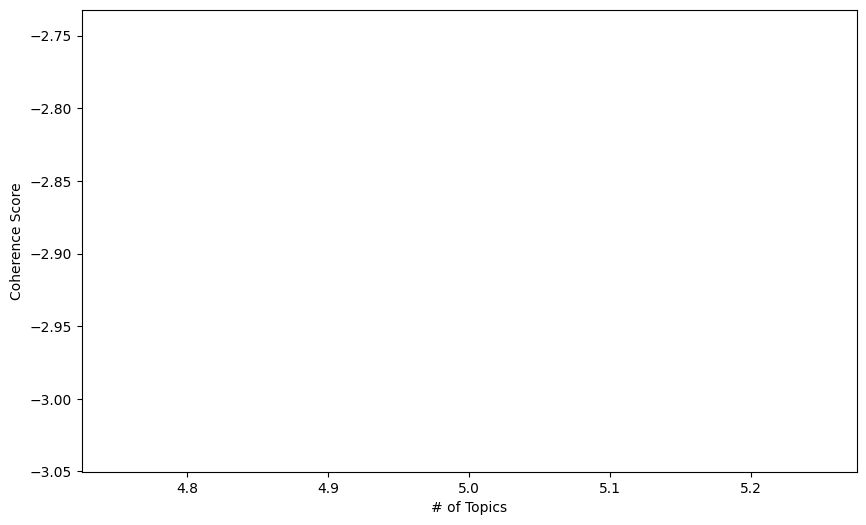

In [26]:

# Load the saved LDA model
#lda_model_up = LdaModel.load("lda_model")

print("N.Topics:", n_topics)
print("Coherence score:", coherence)
plt.figure(figsize=(10,6))
plt.plot(n_topics, coherence)
plt.xlabel('# of Topics')
plt.ylabel('Coherence Score')
plt.show()

In [27]:
#pyLDAvis (https://siqi-zhu.medium.com/ldavis-a-deep-dive-into-the-popular-topic-modeling-tool-d0c61a03e969)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, tfidf_corpus, dictionary, sort_topics=True)
pyLDAvis.display(vis)